In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spotipy
import sys
import pprint
import warnings
warnings.filterwarnings("ignore")
import math
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id='653cfed9a26e46dca3e3e211ded03c0f',\
                                                      client_secret='a14b7886714c41c383458b26434d60cc')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
import spotipy
import json
import time
import copy
import scipy.sparse as ssp
from collections import Counter, defaultdict
import tqdm
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from scipy.stats import pearsonr
from __future__ import print_function    
import time
from scipy import stats as sss
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score as auc
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.neural_network import MLPRegressor
import pickle
from scipy import io
from sklearn.preprocessing import scale
import seaborn

In [5]:
train_df = pd.read_csv('/Users/osx/Desktop/Warner Music Dissertation/Data/train_data.csv')

In [1]:
# train_df['track_name'].value_counts()

In [ ]:
train_df = train_df.drop('Unnamed: 0',axis=1)

### Dictionary Based methods to build user_item matirx quickly, then do similarity based algorithm.

In [ ]:
music = train_df[['customer_id','track_name']]
music.sort_values('customer_id',inplace=True)

track_set = music['track_name'].unique()
users_, tracks = music.T.values

In [ ]:
user, index = np.unique(users_,True)
user_history = np.split(tracks,index[1:])

index_to_user_dict = dict(enumerate(user,start=0))
index_to_track_id = dict(enumerate(track_set,start=0))

inv_track_id_map = {v: k for k, v in index_to_track_id.items()}

In [86]:
np.save('train_user_map_17',index_to_user_dict)
np.save('train_track_map_17',index_to_track_id)
# np.save('inv_track_map_17',inv_track_id_map)

In [87]:
t={u:defaultdict(int) for u in user}

for u,history in zip(user,user_history):
        for song in history:
            t[u][song]+=1

In [88]:
np.save('trainset_Dict_17',t)

In [89]:
# for total tracks listened by part user 
temp_track = []
for i in tqdm.tqdm(range(17000)):
    temp_track.extend(list(t[index_to_user_dict[i]].keys()))
temp_track = set(temp_track)

100%|██████████| 17000/17000 [00:00<00:00, 170732.05it/s]


In [90]:
col_num = len(temp_track)

In [66]:
col_num

18419

In [11]:
# mat = sp.dok_matrix((5512072,27687 1), dtype=np.int64)
# for i in tqdm.tqdm(range(5512072)):
#     for j in t[index_to_user_dict[i]].keys():
#         k = inv_track_id_map[j]
#         mat[i,k] = t[index_to_user_dict[i]][index_to_track_id[k]] 

In [92]:
mat = ssp.dok_matrix((17000,col_num))

for i in tqdm.tqdm(range(17000)):
    for j in t[index_to_user_dict[i]].keys():
        k = inv_track_id_map[j]
        mat[i,k] = t[index_to_user_dict[i]][index_to_track_id[k]] 

100%|██████████| 17000/17000 [00:00<00:00, 17564.58it/s]


In [93]:
mat_csr_track = mat.transpose().tocsr()
mat_csr_user = mat.tocsr()

In [94]:
io.mmwrite("user_item_17.mtx", mat_csr_user)

### user based similarity

###### Cosine Similarity recommender

In [17]:
### Original cosine similarity calculation
start = time.time()
prod_matrix = mat_csr_user.dot(mat_csr_track)
delta = time.time() - start
print ("This matrix dot product finish in %.2f seconds" % (delta,))

This matrix dot product finish in 0.12 seconds


In [18]:
D_dic = {}
for i in tqdm.tqdm(range(15000)):
    D_dic[i] = 1/math.sqrt(sum({k:pow(v,2)for k,v in t[index_to_user_dict[i]].items()}.values()))

100%|██████████| 15000/15000 [00:00<00:00, 163900.61it/s]


In [19]:
denom_mat = ssp.dok_matrix((15000,1))
for i in tqdm.tqdm(range(15000)):
    denom_mat[i,0] = D_dic[i] 

100%|██████████| 15000/15000 [00:00<00:00, 105250.71it/s]


In [20]:
start = time.time()
den_mat = denom_mat.dot(denom_mat.transpose())
delta = time.time() - start
print ("This matrix dot product finish in %.2f seconds" % (delta,))

This matrix dot product finish in 3.18 seconds


In [21]:
cosine_user_mat = den_mat.multiply(prod_matrix)

In [28]:
############### create ddenominator here ################
denominator = ssp.dok_matrix((cosine_user_mat.shape[0],1))

for i in tqdm.tqdm(range(cosine_user_mat.shape[0])):
    for j in cosine_user_mat[i,:].toarray():
        denominator[i,0] = 1/sum(np.absolute(j))

100%|██████████| 15000/15000 [00:23<00:00, 627.46it/s]


In [34]:
pre_user = cosine_user_mat.dot(mat_csr_user)
# pre_mat = pre_user - mat_csr_user

In [29]:
# io.mmwrite("user_cosine.mtx", pre_mat)

In [21]:
### Do recommender ###
recommender_c = {}
loop_num = pre_mat.shape[0]
for i in tqdm.tqdm(range(loop_num)):
    b = mat_csr_user[i,:].nonzero()[1]
    #b.sort()
    a = np.argsort(-pre_mat[i,:].toarray()[0])
    orin_ind = a.argsort()
    selected_ind = orin_ind[np.searchsorted(a[orin_ind],b)]
    a = np.delete(a,selected_ind)
    No_1 = index_to_track_id[a[0]]
    No_2 = index_to_track_id[a[1]]
    No_3 = index_to_track_id[a[2]]
    No_4 = index_to_track_id[a[3]]
    No_5 = index_to_track_id[a[4]]
    recommender_c[i]=[No_1,No_2,No_3,No_4,No_5]

100%|██████████| 15000/15000 [00:22<00:00, 663.77it/s]


In [22]:
# recommender_c

In [23]:
# np.save('recommender_cosine_U',recommender_c)

###### Pearson Correlation recommender

In [33]:
# ### use installed package to calculate correlaton is quite slow even for small unique user size.(10 users for 1:16)
# store_Pear = sp.dok_matrix((15000,15000))
# for i in tqdm.tqdm(range(15000)):
#     for j in range(15000):
#         store_Pear[i,j] = pearsonr(mat_csr_user[i,:].toarray()[0],mat_csr_user[j,:].toarray()[0])[0]

In [34]:
### So use matrix product to speed up calculation
# Normaliztion of users listened time minues avg of itself.
mat_csr_user_P = copy.deepcopy(mat_csr_user)

for i in tqdm.tqdm(range(mat_csr_user_P.shape[0])):
    col_ind = mat_csr_user_P[i,:].nonzero()[1]
    avg = mat_csr_user_P[i,col_ind].mean()
    operator = ssp.dok_matrix(mat_csr_user_P.shape,dtype=float)
    for j in col_ind:
        operator[i,j] = avg
    mat_csr_user_P = mat_csr_user_P-operator.tocsr()

100%|██████████| 15000/15000 [00:29<00:00, 507.01it/s]


In [35]:
P_num_u = mat_csr_user_P.dot(mat_csr_user_P.transpose())

In [36]:
P_deno_u = ssp.dok_matrix((mat_csr_user_P.shape[0],1))
# ac_deno = ssp.dok_matrix((mat_ac.shape[0],1))

for i in tqdm.tqdm(range(mat_csr_user_P.shape[0])):
    for j in mat_csr_user_P[i,:].toarray():
        if math.sqrt(sum(j**2)) ==0:
            P_deno_u[i,0] = 0
        else:
            P_deno_u[i,0] = 1/math.sqrt(sum(j**2))

100%|██████████| 15000/15000 [00:42<00:00, 353.70it/s]


In [37]:
P_deno_u = P_deno_u.tocsr()
P_den_u = P_deno_u.dot(P_deno_u.transpose())

In [38]:
P_corr_u = P_num_u.multiply(P_den_u)
P_predict_u = P_corr_u.dot(mat_csr_user)

In [39]:
# io.mmwrite("user_Pearson.mtx", P_predict_u)

In [40]:
### Do recommender ###
recommender_Pu = {}
loop_num = P_predict_u.shape[0]
for i in tqdm.tqdm(range(loop_num)):
    b = mat_csr_user[i,:].nonzero()[1]
    #b.sort()
    a = np.argsort(-P_predict_u[i,:].toarray()[0])
    orin_ind = a.argsort()
    selected_ind = orin_ind[np.searchsorted(a[orin_ind],b)]
    a = np.delete(a,selected_ind)
    No_1 = index_to_track_id[a[0]]
    No_2 = index_to_track_id[a[1]]
    No_3 = index_to_track_id[a[2]]
    No_4 = index_to_track_id[a[3]]
    No_5 = index_to_track_id[a[4]]
    recommender_Pu[i]=[No_1,No_2,No_3,No_4,No_5]

100%|██████████| 15000/15000 [00:22<00:00, 679.00it/s]


In [41]:
# recommender_Pu

In [42]:
# np.save('recommender_Pearson_U',recommender_Pu)

### track based similarity

###### Cosine Similarity recommender

In [43]:
mat_csr_track.shape

(18419, 15000)

In [44]:
### Cosine similarity
track_num = mat_csr_track.dot(mat_csr_user)

In [45]:
track_deno = ssp.dok_matrix((mat_csr_track.shape[0],1))

for i in tqdm.tqdm(range(mat_csr_track.shape[0])):
    track_deno[i,0] = [1/math.sqrt(sum(j**2)) for j in mat_csr_track.getrow(i).toarray()]

100%|██████████| 18419/18419 [00:34<00:00, 520.25it/s]


In [46]:
track_d = track_deno.dot(track_deno.transpose())
cosine_track_mat = track_num.multiply(track_d)
pre_track = mat_csr_user.dot(cosine_track_mat)
# pre_track = pre_track - mat_csr_user

In [ ]:
##########################################
denominator = ssp.dok_matrix((cosine_track_mat.shape[0],1))

for i in tqdm.tqdm(range(cosine_track_mat.shape[0])):
    for j in cosine_track_mat[i,:].toarray():
        denominator[i,0] = 1/sum(np.absolute(j))

In [ ]:
pre_track = pre_track.T.multiply(denominator)
pre_track = pre_track.T

In [47]:
# io.mmwrite("Item_cosine.mtx", pre_track)

In [48]:
### Do recommender ###
recommender_tc = {}
loop_num = pre_track.shape[0]
for i in tqdm.tqdm(range(loop_num)):
    b = mat_csr_user[i,:].nonzero()[1]
    #b.sort()
    a = np.argsort(-pre_track[i,:].toarray()[0])
    orin_ind = a.argsort()
    selected_ind = orin_ind[np.searchsorted(a[orin_ind],b)]
    a = np.delete(a,selected_ind)
    No_1 = index_to_track_id[a[0]]
    No_2 = index_to_track_id[a[1]]
    No_3 = index_to_track_id[a[2]]
    No_4 = index_to_track_id[a[3]]
    No_5 = index_to_track_id[a[4]]
    recommender_tc[i]=[No_1,No_2,No_3,No_4,No_5]

100%|██████████| 15000/15000 [00:24<00:00, 614.34it/s]


In [49]:
# recommender_tc

In [50]:
# np.save('recommender_cosine_T',recommender_tc)

In [51]:
# Adjusted Cosine similarity
# Normaliztion of users listened time minues avg of itself. mat_csr_user_P
ac_num_t = mat_csr_user_P.transpose().dot(mat_csr_user_P)

In [ ]:
mat_ac_tt = mat_csr_user_P.transpose()
num_t = mat_ac_tt.shape[0]
ac_deno_t = ssp.dok_matrix((num_t,1))

for i in tqdm.tqdm(range(num_t)):
    for j in mat_ac_tt.getrow(i).toarray():
        if math.sqrt(sum(j**2))==0:
            ac_deno_t[i,0]=0
        else:
            ac_deno_t[i,0]=1/math.sqrt(sum(j**2))

100%|██████████| 18419/18419 [01:00<00:00, 303.82it/s]


In [ ]:
ac_den_t = ac_deno_t.dot(ac_deno_t.transpose())
ac_sim_t = ac_num_t.multiply(ac_den_t)
ac_predict = mat_csr_user.dot(ac_sim_t)

In [ ]:
# io.mmwrite("Item_adjusted_cosine.mtx", ac_predict)

In [ ]:
### Do recommender ###
recommender_tac = {}
loop_num = ac_predict.shape[0]
for i in tqdm.tqdm(range(loop_num)):
    b = mat_csr_user[i,:].nonzero()[1]
    #b.sort()
    a = np.argsort(-ac_predict[i,:].toarray()[0])
    orin_ind = a.argsort()
    selected_ind = orin_ind[np.searchsorted(a[orin_ind],b)]
    a = np.delete(a,selected_ind)
    No_1 = index_to_track_id[a[0]]
    No_2 = index_to_track_id[a[1]]
    No_3 = index_to_track_id[a[2]]
    No_4 = index_to_track_id[a[3]]
    No_5 = index_to_track_id[a[4]]
    recommender_tac[i]=[No_1,No_2,No_3,No_4,No_5]

In [ ]:
# recommender_tac

In [ ]:
# np.save('recommender_adjuested_cosine_T',recommender_tac)

###### Pearson correlation recommender

In [ ]:
mat_csr_track_P = copy.deepcopy(mat_csr_track)

# Normaliztion of tracks listened time minues avg of itself.
for i in tqdm.tqdm(range(mat_csr_track_P.shape[0])):
    non_col = mat_csr_track_P.getrow(i).nonzero()[1]
    avg = mat_csr_track_P[i,non_col].mean()
    operator = ssp.dok_matrix(mat_csr_track_P.shape)
    for j in non_col:
        operator[i,j] = avg
    mat_csr_track_P = mat_csr_track_P-operator.tocsr()

In [ ]:
P_num = mat_csr_track_P.dot(mat_csr_track_P.transpose())

In [ ]:
Pear_deno = ssp.dok_matrix((mat_csr_track_P.shape[0],1))

for i in tqdm.tqdm(range(mat_csr_track_P.shape[0])):
    for j in mat_csr_track_P.getrow(i).toarray():
        if math.sqrt(sum(j**2)) ==0:
            Pear_deno[i,0] = 0
        else:
            Pear_deno[i,0] = 1/math.sqrt(sum(j**2)) 

In [ ]:
Pear_deno = Pear_deno.tocsr()
P_den = Pear_deno.dot(Pear_deno.transpose())
Pear_corr = P_den.multiply(P_num)
P_predict = mat_csr_user.dot(Pear_corr)

In [ ]:
# io.mmwrite("Item_Pearson.mtx", P_predict)

In [ ]:
### Do recommender ###
recommender_Pt = {}
loop_num = P_predict.shape[0]
for i in tqdm.tqdm(range(loop_num)):
    b = mat_csr_user[i,:].nonzero()[1]
    #b.sort()
    a = np.argsort(-P_predict[i,:].toarray()[0])
    orin_ind = a.argsort()
    selected_ind = orin_ind[np.searchsorted(a[orin_ind],b)]
    a = np.delete(a,selected_ind)
    No_1 = index_to_track_id[a[0]]
    No_2 = index_to_track_id[a[1]]
    No_3 = index_to_track_id[a[2]]
    No_4 = index_to_track_id[a[3]]
    No_5 = index_to_track_id[a[4]]
    recommender_Pt[i]=[No_1,No_2,No_3,No_4,No_5]

In [ ]:
# recommender_Pt

In [72]:
# np.save('recommender_Pearson_T',recommender_Pt)

### Content-based algorithm

In [3]:
track_uni_=np.load('track_feature_1.npy').item()

In [6]:
features_of_track = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',\
                     'acousticness', 'instrumentalness', 'liveness', 'valence','tempo',\
                    'duration_ms', 'time_signature']

index_to_features = dict(enumerate(features_of_track,start=0))
inv_features_map = {v: k for k, v in index_to_features.items()}

In [7]:
feature_df = pd.DataFrame.from_dict(track_uni_).T
features_to_drop = ['analysis_url','id','track_href','type','uri']
feature_df.drop(features_to_drop,axis=1,inplace=True)

In [8]:
for i in features_of_track:
    feature_df[i].fillna(feature_df[i].mean(),inplace=True)
#     feature_df[i] = (feature_df[i]-feature_df[i].mean())/feature_df[i].std()

track_dict = pd.DataFrame.to_dict(feature_df.T)

In [ ]:
tf_mat = ssp.dok_matrix((col_num,13))

for i in tqdm.tqdm(range(col_num)):
    for j in features_of_track:
        k = inv_features_map[j]
        tf_mat[i,k] = track_dict[index_to_track_id[i]][j]

In [ ]:
content_num = tf_mat.dot(tf_mat.transpose())

In [ ]:
content_deno = ssp.dok_matrix((tf_mat.shape[0],1))

for i in tqdm.tqdm(range(tf_mat.shape[0])):
    for j in tf_mat.getrow(i).toarray():
        if math.sqrt(sum(j**2)) ==0:
            content_deno[i,0] = 0
        else:
            content_deno[i,0] = 1/math.sqrt(sum(j**2)) 

In [ ]:
content_den = content_deno.dot(content_deno.transpose())
content_cos = content_den.multiply(content_num)
content_predict = mat_csr_user.dot(content_cos)

In [ ]:
io.mmwrite("Content_based_without_.mtx", content_predict)

In [ ]:
### Do recommender ###
recommender_CB = {}
loop_num = content_predict.shape[0]
for i in tqdm.tqdm(range(loop_num)):
    b = mat_csr_user[i,:].nonzero()[1]
    #b.sort()
    a = np.argsort(-content_predict[i,:].toarray()[0])
    orin_ind = a.argsort()
    selected_ind = orin_ind[np.searchsorted(a[orin_ind],b)]
    a = np.delete(a,selected_ind)
    No_1 = index_to_track_id[a[0]]
    No_2 = index_to_track_id[a[1]]
    No_3 = index_to_track_id[a[2]]
    No_4 = index_to_track_id[a[3]]
    No_5 = index_to_track_id[a[4]]
    recommender_CB[i]=[No_1,No_2,No_3,No_4,No_5]

In [ ]:
np.save('recommender_content_based_without_',recommender_CB)

# Combine the recommendation from similarity based algorithm with Supervised Learning algorithm

### Generate traing set and test set

In [163]:
### Generate training data of the user used in user_item matrix dataframe

sup_user = []
for i in tqdm.tqdm(range(20000)):
    sup_user.append(index_to_user_dict[i])

sup_df = pd.DataFrame(sup_user)
sup_df = sup_df.rename(columns={0:'customer_id'})
train = pd.merge(sup_df, train_df, on=['customer_id'])


100%|██████████| 20000/20000 [00:05<00:00, 3671.10it/s]


In [164]:
train.shape

(128244, 31)

In [165]:
sup_df.shape

(20000, 1)

In [361]:
### Generate the test data of the user used in user_item matrix dataframe
test_dc = {}
test_dPu = {}
test_dtc = {}
test_dtac = {}
test_dPt = {}

for i in tqdm.tqdm(range(len(recommender_c))):
    test_dc[index_to_user_dict[i]]=recommender_c[i]
    test_dPu[index_to_user_dict[i]]=recommender_Pu[i]
    test_dtc[index_to_user_dict[i]]=recommender_tc[i]
    test_dtac[index_to_user_dict[i]]=recommender_tac[i]
    test_dPt[index_to_user_dict[i]]=recommender_Pt[i]

######################### for recommender_c #########################
t_tc = pd.DataFrame.from_dict(test_dc,orient='index')

track_c_0 = pd.DataFrame(t_tc[0]).rename(columns={0:'track'})
track_c_1 = pd.DataFrame(t_tc[1]).rename(columns={1:'track'})
track_c_2 = pd.DataFrame(t_tc[2]).rename(columns={2:'track'})
track_c_3 = pd.DataFrame(t_tc[3]).rename(columns={3:'track'})
track_c_4 = pd.DataFrame(t_tc[4]).rename(columns={4:'track'})

test_c = pd.concat([track_c_0,track_c_1,track_c_2,track_c_3,track_c_4])

######################### for recommender_Pu #########################
t_tPu = pd.DataFrame.from_dict(test_dPu,orient='index')

track_Pu_0 = pd.DataFrame(t_tPu[0]).rename(columns={0:'track'})
track_Pu_1 = pd.DataFrame(t_tPu[1]).rename(columns={1:'track'})
track_Pu_2 = pd.DataFrame(t_tPu[2]).rename(columns={2:'track'})
track_Pu_3 = pd.DataFrame(t_tPu[3]).rename(columns={3:'track'})
track_Pu_4 = pd.DataFrame(t_tPu[4]).rename(columns={4:'track'})

test_Pu = pd.concat([track_Pu_0,track_Pu_1,track_Pu_2,track_Pu_3,track_Pu_4])

######################### for recommender_tc #########################
t_ttc = pd.DataFrame.from_dict(test_dtc,orient='index')

track_tc_0 = pd.DataFrame(t_ttc[0]).rename(columns={0:'track'})
track_tc_1 = pd.DataFrame(t_ttc[1]).rename(columns={1:'track'})
track_tc_2 = pd.DataFrame(t_ttc[2]).rename(columns={2:'track'})
track_tc_3 = pd.DataFrame(t_ttc[3]).rename(columns={3:'track'})
track_tc_4 = pd.DataFrame(t_ttc[4]).rename(columns={4:'track'})

test_tc = pd.concat([track_tc_0,track_tc_1,track_tc_2,track_tc_3,track_tc_4])

######################### for recommender_tac #########################
t_ttac = pd.DataFrame.from_dict(test_dtac,orient='index')

track_tac_0 = pd.DataFrame(t_ttac[0]).rename(columns={0:'track'})
track_tac_1 = pd.DataFrame(t_ttac[1]).rename(columns={1:'track'})
track_tac_2 = pd.DataFrame(t_ttac[2]).rename(columns={2:'track'})
track_tac_3 = pd.DataFrame(t_ttac[3]).rename(columns={3:'track'})
track_tac_4 = pd.DataFrame(t_ttac[4]).rename(columns={4:'track'})

test_tac = pd.concat([track_tac_0,track_tac_1,track_tac_2,track_tac_3,track_tac_4])

######################### for recommender_Pt #########################
t_tPt = pd.DataFrame.from_dict(test_dPt,orient='index')

track_Pt_0 = pd.DataFrame(t_tPt[0]).rename(columns={0:'track'})
track_Pt_1 = pd.DataFrame(t_tPt[1]).rename(columns={1:'track'})
track_Pt_2 = pd.DataFrame(t_tPt[2]).rename(columns={2:'track'})
track_Pt_3 = pd.DataFrame(t_tPt[3]).rename(columns={3:'track'})
track_Pt_4 = pd.DataFrame(t_tPt[4]).rename(columns={4:'track'})

test_Pt = pd.concat([track_Pt_0,track_Pt_1,track_Pt_2,track_Pt_3,track_Pt_4])


100%|██████████| 15000/15000 [00:00<00:00, 371398.65it/s]


In [362]:
test = pd.concat([test_c,test_Pu,test_tc,test_tac,test_Pt])
test.reset_index(inplace=True)
test.rename(columns={'index':'customer_id','track':'track_name'},inplace=True)

In [16]:
# test.to_csv('raw_recommendation.csv')

### Features Engineering

In [2]:
features_to_drop = ['day','log_time','mobile','isrc','upc','postal_code','country_code','gender',\
                    'filename','region_code','offline_timestamp','stream_length','referral_code',\
                    'partner_name','financial_product','user_product_type','stream_cached','stream_source',\
                    'stream_source_uri','stream_device','stream_os','track_uri','track_artists','source',\
                    'access','track_id']
train = train.drop(features_to_drop,axis=1)

In [51]:
# ### decide whether several features are unique for each customer
# temp_1 = train_df[['access','customer_id']]
# temp_1.sort_values('customer_id',inplace=True)
# temp_1.dropna(axis=0,how='any',inplace=True)

# par_name, custo_ = temp_1.T.values
# custo, index = np.unique(custo_,True)
# par_set = np.split(par_name,index[1:])

# i=0
# for e in par_set:
#     if len(set(e))>1:
#         print(i,'one customer has multiple parnter')
#     i=i+1

In [16]:
### Using dictionary to add ratings for training data
hehe = {}
for i in range(20000):
    for j,l in t[index_to_user_dict[i]].items():
        hehe[(index_to_user_dict[i],j)]=l

In [17]:
train.drop_duplicates(subset=['customer_id','track_name'],inplace=True)
label_df = pd.Series(hehe).reset_index()
label_df.rename(columns={'level_0':'customer_id','level_1':'track_name',0:'ratings'},inplace=True)
train = pd.merge(train, label_df, on=['customer_id','track_name'])

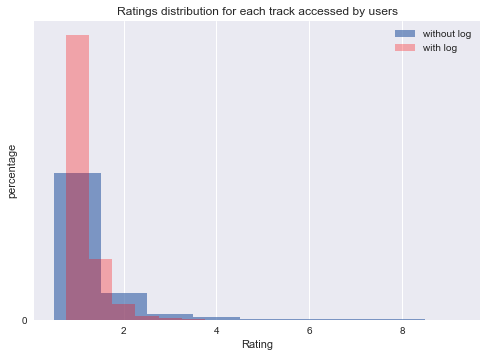

In [61]:
ratings_ = label_df.ratings
plt.hist(ratings_, bins=np.arange(1,10), alpha=0.7,align="left",\
         normed=True,histtype="bar",label="without log",)

plt.hist(np.log(ratings_), bins=np.arange(1,10,0.5), alpha=0.3,align="left",\
         normed=True,histtype="bar",label="with log",color="r")

plt.xticks()
plt.yticks(range(0,1))
plt.title("Ratings distribution for each track accessed by users")
plt.xlabel('Rating')
plt.ylabel('percentage')
plt.legend()
plt.show()

In [26]:
sss.describe(label_df.ratings)

DescribeResult(nobs=96090, minmax=(1, 145), mean=1.3346237901966906, variance=1.4487663171644583, skewness=33.25367920374718, kurtosis=2848.6753778816346)

In [69]:
sss.describe(np.log(label_df.ratings))

DescribeResult(nobs=96090, minmax=(0.0, 4.9767337424205742), mean=0.17857433823843644, variance=0.15142376994648829, skewness=2.4498515981539826, kurtosis=7.267680217254902)

In [53]:
### Using DataFrame to add label of ratings.
# train['ratings']=0

# for i in tqdm.tqdm(range(20000)):
#     for j in t[index_to_user_dict[i]].keys():
#         train['ratings'][train['customer_id']==index_to_user_dict[i]][train['track_name']==j]=\
#         t[index_to_user_dict[i]][j]

#train.to_csv('train_set.csv')

In [257]:
track_uni_ = {}
track_uni = train['track_name'].unique()
sp.trace=False
for track in tqdm.tqdm(track_uni):
    features = {}
    for i in range(100):
        results = sp.search(q=track, limit=50)
        if (results!=None):
            break
        if(i==99):
            print('Unable to obtain a meaningful result!')
#     tids = []
    for j in range(100):
        try:
            for i, t in enumerate(results['tracks']['items']):
                if t['name']==track:
                    tids=t['uri']
            break
        except:
            continue
        
    while(1):
        try:
            features = sp.audio_features(tids)[0] ### get features
            track_uni_[track]=features
            break
        except:
            continue
    


 19%|█▉        | 4265/21983 [17:20<54:23,  5.43it/s]  

retrying ...0secs
retrying ...0secs
retrying ...0secs


 19%|█▉        | 4266/21983 [17:20<1:20:32,  3.67it/s]

retrying ...0secs


 20%|█▉        | 4357/21983 [17:39<58:25,  5.03it/s]  

retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs


 20%|█▉        | 4358/21983 [17:40<1:44:30,  2.81it/s]

retrying ...0secs


 28%|██▊       | 6098/21983 [24:39<54:38,  4.84it/s]  

retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs


 55%|█████▍    | 11984/21983 [47:19<36:44,  4.54it/s]  

retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs


 55%|█████▍    | 11985/21983 [47:20<53:13,  3.13it/s]

retrying ...0secs
retrying ...0secs


 55%|█████▍    | 12079/21983 [47:40<28:51,  5.72it/s]  

retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs


 55%|█████▍    | 12080/21983 [47:40<42:45,  3.86it/s]

retrying ...0secs


 55%|█████▌    | 12129/21983 [47:49<26:08,  6.28it/s]

retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs


 55%|█████▌    | 12130/21983 [47:50<1:09:53,  2.35it/s]

retrying ...0secs


 57%|█████▋    | 12473/21983 [49:00<33:02,  4.80it/s]  

retrying ...0secs
retrying ...0secs
retrying ...0secs


 71%|███████   | 15599/21983 [1:01:19<21:28,  4.96it/s]  

retrying ...1secs


 73%|███████▎  | 15983/21983 [1:02:50<16:52,  5.93it/s]  

retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs


 76%|███████▌  | 16700/21983 [1:05:29<16:14,  5.42it/s]

retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs
retrying ...0secs


 76%|███████▌  | 16701/21983 [1:05:30<31:30,  2.79it/s]

retrying ...0secs


 80%|███████▉  | 17495/21983 [1:08:40<15:23,  4.86it/s]

retrying ...0secs


 85%|████████▍ | 18676/21983 [1:13:00<12:21,  4.46it/s]

retrying ...0secs


 86%|████████▌ | 18814/21983 [1:13:30<14:02,  3.76it/s]

retrying ...0secs
retrying ...0secs
retrying ...0secs


 91%|█████████ | 19901/21983 [1:17:35<06:58,  4.98it/s]

retrying ...1secs


100%|██████████| 21983/21983 [1:25:30<00:00,  4.73it/s]


In [118]:
# np.save('track_feature_1',track_uni_)

In [3]:
track_uni_=np.load('track_feature_1.npy').item()

In [3]:
song_feature = pd.DataFrame(track_uni_).T

features_to_drop = ['analysis_url','id','track_href','type','uri']
song_feature = song_feature.drop(features_to_drop,axis=1).astype(float)
song_feature.reset_index(inplace=True)
song_feature.rename(columns={'index':'track_name'},inplace=True)

train = pd.merge(train, song_feature, on=['track_name'])

In [172]:
np.any(train['birth_year'].isnull()==True)

True

In [174]:
train['birth_year'] = train['birth_year'].astype(float)

In [175]:
pd.DataFrame({'birthe_year':list(sss.describe(train['birth_year'].dropna()))},\
             index=["nobs","min-max","mean","variance","skewness","kurtosis"])

,birthe_year
nobs,95105
min-max,"(1900.0, 2008.0)"
mean,1985.53
variance,149.117
skewness,-1.52839
kurtosis,3.78622


In [176]:
train['birth_year'].fillna(1993,inplace=True)
train['birth_year'] = train['birth_year'].map(lambda x : round(x))

In [ ]:
need_fill = ['acousticness', 'danceability','duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',\
             'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
for i in need_fill:
    train[i].fillna(train[i].mode(),inpalce=True)

In [359]:
# train.to_csv('train_supervised.csv')

In [2]:
# #read
train = pd.read_csv('/Users/osx/Desktop/Warner Music Dissertation/Code/train_supervised.csv')
train = train.drop('Unnamed: 0',axis=1)

In [3]:
y_label = train['ratings']
x_input = train.drop('ratings',axis=1)
x_user = x_input.drop('customer_id',axis=1)

In [364]:
### final test dataframe ###
test = pd.merge(test,song_feature,on=['track_name']) # Add features of track columns
test = pd.merge(test,x_input[['customer_id','birth_year']].drop_duplicates(subset=['customer_id']), on=['customer_id'])
test = pd.merge(test,x_input[['track_name','artist_name','album_name']].drop_duplicates(subset=['track_name']),\
                            on=['track_name'])

In [ ]:
need_fill = ['acousticness', 'danceability','duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',\
             'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']
for i in need_fill:
    test[i].fillna(test[i].mode(),inpalce=True)

In [430]:
# test.to_csv('test_supervised.csv')

In [2]:
# #read
test = pd.read_csv('/Users/osx/Desktop/Warner Music Dissertation/Code/test_supervised.csv')
test = test.drop(['Unnamed: 0','customer_id'],axis=1)

In [7]:
np.any(train.isnull()==True)

False

In [13]:
dummied_x = pd.get_dummies(x_input)

In [3]:
dummied_test = pd.get_dummies(test)